In [1]:
%matplotlib inline
import nibabel
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from ipywidgets import interact, widget, IntSlider
from skimage import measure

In [2]:
folderpath = "/home/snarduzz/Data/"
lesion_files = [os.path.join(folderpath,x) for x in os.listdir(folderpath) if x.startswith("wcoreg") and ("VOI") in x]
t2_files =  [os.path.join(folderpath,x) for x in os.listdir(folderpath) if x.startswith("wcoreg") and ("t2") in x]
#check integrity
assert(len(t2_files)==len(lesion_files))
brain_file = t2_files[0]

# Load data of patients
list_lesion_data = []
for file in lesion_files:
    x = nibabel.load(file).get_data()
    list_lesion_data.append(x)
numpy_lesions = np.array(list_lesion_data)

# Load a reference MRI coregistrated scan
T2 = nibabel.load(brain_file).get_data()

print("Number of patients : {}".format(len(lesion_files)))

Number of patients : 37


The dataset contains 37 valid patients (scan can be coregistrated).

## Location of lesions

In [3]:
s = np.sum(numpy_lesions,axis=0)
voxel_size = [np.sum(x) for x in numpy_lesions]

merged_image = np.empty(shape=(s.shape[0], s.shape[1], s.shape[2],3))
merged_image[:,:,:,0] = (s/np.max(s))
merged_image[:,:,:,2] = (T2/np.max(T2))

In [4]:
def plot_lesion_heatmap(layer):
    ax = plt.figure(figsize=[10,10])
    plt.imshow((merged_image[:,:,layer,:]* 255).astype(np.uint8))
    plt.title("Sum of lesion locations",fontsize=20)
    norm = colors.Normalize(vmin=0, vmax=np.max(s))
    
    #Create colormap
    C = np.array([(x,0,0) for x in range(255)]) # Black to red, linear
    cm = colors.ListedColormap(C/255.0)
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm.set_array([])
    plt.colorbar(sm,fraction=0.0385, pad=0.04)

In [5]:
interactive_plot = interact(plot_lesion_heatmap, layer=IntSlider(min=0,max=s.shape[2]-1,step=1,value=40))

interactive(children=(IntSlider(value=40, description='layer', max=78), Output()), _dom_classes=('widget-inter…

We can observe that the dataset is imbalanced, with about 30% of the patient that have a lesion in the right 

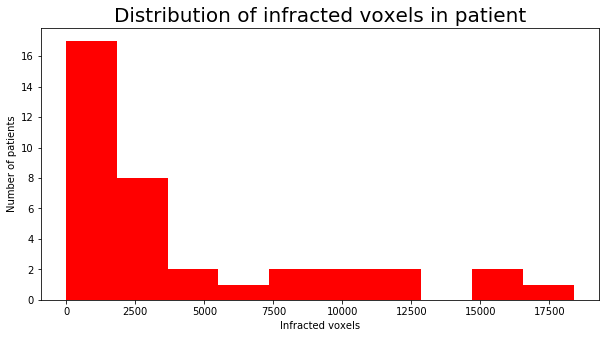

In [6]:
plt.figure(figsize=(10,5))
plt.hist(voxel_size,color="r")
plt.title("Distribution of infracted voxels in patient",size=20)
plt.xlabel("Infracted voxels")
plt.ylabel("Number of patients")
plt.show()

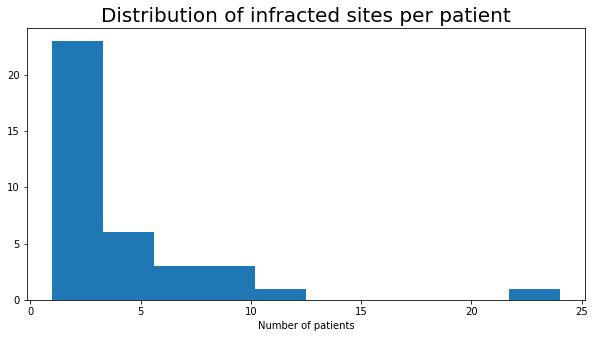

In [7]:
number_lesions = [np.max(measure.label(x, background=0)) for x in list_lesion_data]
plt.figure(figsize=[10,5])
plt.hist(number_lesions)
plt.title("Distribution of infracted sites per patient",size=20)
plt.xlabel("Number of infracted sites")
plt.xlabel("Number of patients")
plt.show()

## Numerical analysis of Input Data

In [8]:
def normalize(img):
    mean = np.mean(img)
    std = np.std(img)
    return (img-mean)/std

In [20]:
from tqdm import tqdm
normalized_imgs = []
lesions_data = []
non_lesion_data = []

for file in tqdm(t2_files):
    lesion_file = file.replace("t2_tse_tra","VOI_lesion")
    x = nibabel.load(file).get_data()
    y = nibabel.load(lesion_file).get_data()
    img = normalize(x)
    
    # get indices where lesion=1
    lesion = img[np.where(y==1)]
    non_lesion = img[np.where(y==0)]
    
    img = list(img.flatten())
    
    normalized_imgs.append(img)
    lesions_data.append(lesion)
    non_lesion_data.append(non_lesion)


100%|██████████| 37/37 [00:02<00:00, 14.93it/s]

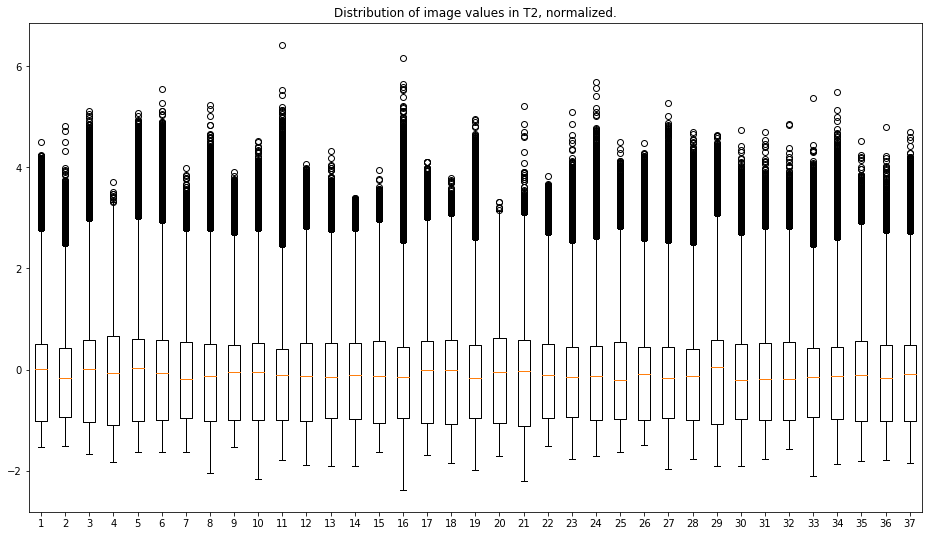

In [21]:
plt.figure(figsize=[16,9])
plt.boxplot(normalized_imgs)
plt.title("Distribution of image values in T2, normalized.")
plt.show()

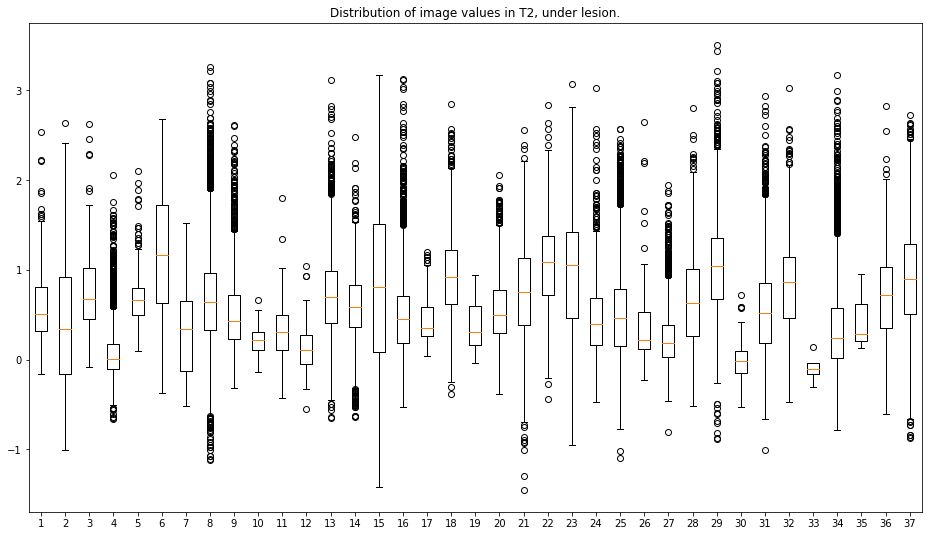

In [22]:
plt.figure(figsize=[16,9])
plt.boxplot(lesions_data)
plt.title("Distribution of image values in T2, under lesion.")
plt.show()

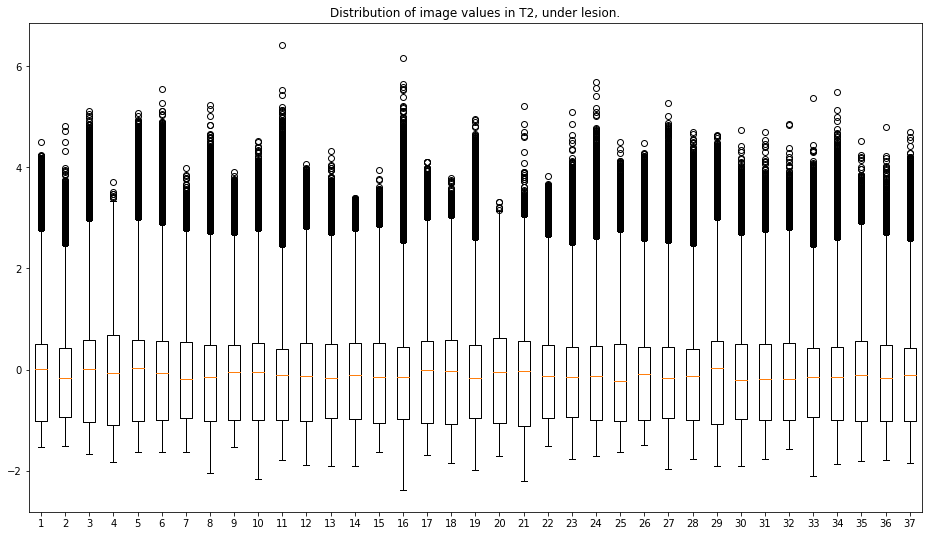

In [24]:
plt.figure(figsize=[16,9])
plt.boxplot(non_lesion_data)
plt.title("Distribution of image values in T2, under lesion.")
plt.show()